This notebook studies the behavior of a group of 360 crystals in the same ieta (currently 66) ring. It also combines the data into a new dataframe for quick analysis in the future.

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker
#now lets try some autoregression
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.preprocessing import MinMaxScaler

In [2]:
#load in the data, specifying the year helps at the end, when it writes out the combined dataframe
year="2016"
test = pd.read_csv('/home/rusack/evans908/FAIR/dataframes/slimmed_df_ieta66_'+year+'.csv', index_col=0)
geom = pd.read_csv('/home/rusack/evans908/FAIR/ECAL_RADDAM_Data/geom/ecal_geom.csv', index_col=0)


/panfs/roc/msisoft/anaconda/python3-2020.07-mamba/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#just to get oriented
test.columns

Index(['Unnamed: 1', 'iov_idx', 'fill', 'temperature', 'good', 't1',
       'seq_datetime', 'start_ts', 'stop_ts', 'hlt_key', 'sequence', 'ecal',
       'd_lumi', 'r_lumi', 'bfield', 'feds_included', 'hdf_name', 'inst_lumi',
       'laser_datetime', 'date_y', 'calibration', 'int_inst_lumi', 'p1', 'p2',
       'p3', 'time', '#run:fill', 'ls', 'beamstatus', 'E(GeV)',
       'delivered(/ub)', 'recorded(/ub)', 'avgpu', 'source',
       'int_deliv_inv_ub', 'int_record_inv_ub'],
      dtype='object')

In [4]:
#The crystal with index 54000 is pretty well behaved and a good sanity check vs other crystals/combined data
df_54000 = test[test.index == 54000]

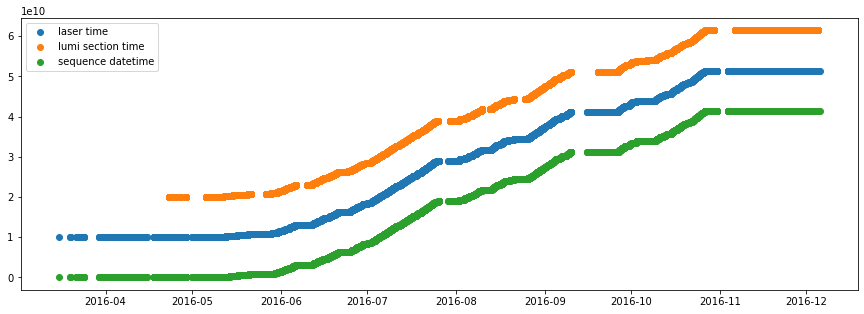

In [5]:
#there are three timestamps in the data, the time the laser fires on the crystal, 
#the time the calibration sequence starts, the time of the lumi-section
#laser firing time and lumi-section time are matched to get the luminosity data.
#so, generally, only entries with a laser time should be used.
fig, ax = plt.subplots(figsize=(15,5))

ax.scatter(pd.to_datetime(df_54000.laser_datetime), df_54000.int_deliv_inv_ub+1e10, label="laser time")
ax.scatter(pd.to_datetime(df_54000.time), df_54000.int_deliv_inv_ub+2e10, label = "lumi section time")
ax.scatter(pd.to_datetime(df_54000[df_54000.laser_datetime.notna()].seq_datetime), df_54000[df_54000.laser_datetime.notna()].int_deliv_inv_ub, label = "sequence datetime")

ax.legend()

In [6]:
#simply way to process groups of crystals
def digest(grp):
    slimmed = grp[1][['calibration','laser_datetime']].copy()
    slimmed.loc[:,'laser_datetime'] = pd.to_datetime(slimmed.laser_datetime)
    return (grp[0], slimmed.reset_index()) #since different crystals in the ring will have slightly different times, you need to explicitly nuke the index to get them next to each other

In [7]:
#some list comprehension on that function
grps = [digest(grp) for grp in test.groupby(test.index)]

In [8]:
#now we can make a dataframe where each column is a crystal and the rows are calibration values
multi_df = grps[0][1].copy()

for grp in grps:
  #  print(grp[0])
  #  print(grp[1])
    multi_df[grp[0]] = grp[1].calibration
multi_df_clean = multi_df.drop(['index','calibration','laser_datetime'],axis=1)

In [9]:
multi_df_clean

,54000,54001,54002,54003,54004,54005,54006,54007,54008,54009,...,54350,54351,54352,54353,54354,54355,54356,54357,54358,54359
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.946416,0.916027,0.945919,0.913327,0.919796,0.929371,0.931192,0.936219,0.934615,0.938433,...,0.925052,0.898287,0.914282,0.951986,0.953240,0.962441,0.938009,0.907674,0.929801,0.930462
8138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.924153,0.897773,0.913782,0.952136,0.953588,0.961546,0.937849,0.907153,0.929835,0.929601
8139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.924920,0.898722,0.914476,0.952763,0.953840,0.962401,0.938758,0.908009,0.930115,0.930627


In [10]:
#now we can make a correlation matrix between them
corr = multi_df_clean.corr()

In [11]:
#the worst correlation....
corr.min().min()

-0.45031335082376645

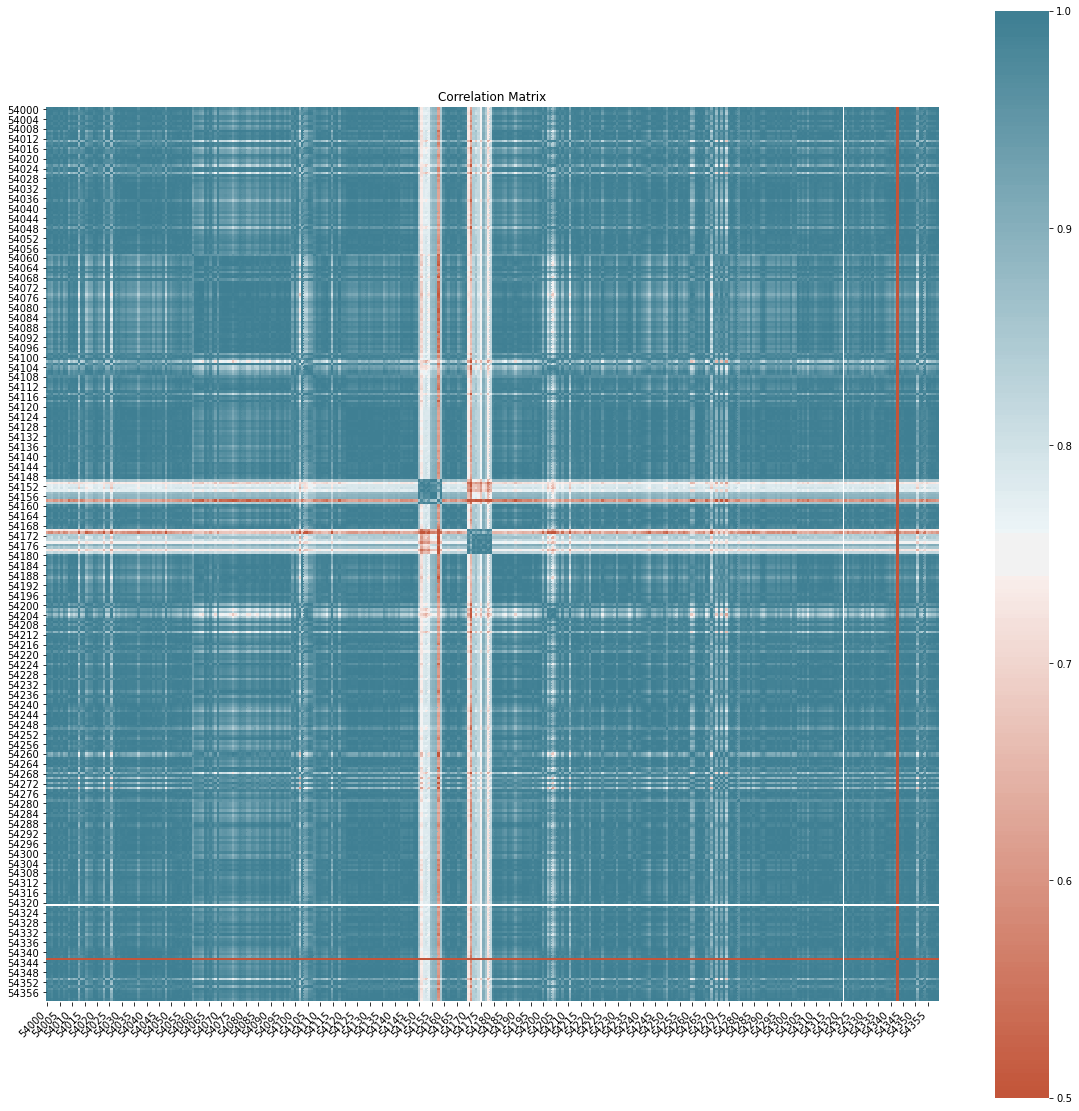

In [12]:
#lets plot the correlation matrix
fig, ax = plt.subplots(figsize=(20,20))

ax.set_title('Correlation Matrix')
corr1 = multi_df_clean.corr()
ax = sns.heatmap(
    corr1, 
    vmin=0.50, vmax=1, center=0.75,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
#fix for matplotlib 3.1.1 issue (fixed in 3.1.2??)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [13]:
#let's build a combined view of all of the crystals, working as we did, but now extracting specifice parts of each crystals data
group = test.groupby(test.index)
calibrations = pd.concat([grp.reset_index()[['calibration']] for _,grp in group], axis=1)
datetimes = pd.concat([grp.reset_index()[['laser_datetime']] for _,grp in group], axis=1)
lumis = pd.concat([grp.reset_index()[['int_deliv_inv_ub']] for _,grp in group], axis=1)

In [14]:
#lets check, note that we aren't going to use crystal indices at this point, so the redundant columns are ok
datetimes

,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,...,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime,laser_datetime
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,2016-12-05 13:56:29,2016-12-05 13:56:29,2016-12-05 13:56:29,2016-12-05 13:56:29,2016-12-05 13:56:29,2016-12-05 13:56:29,2016-12-05 13:56:29,2016-12-05 13:56:29,2016-12-05 13:56:29,2016-12-05 13:56:29,...,2016-12-05 13:45:22,2016-12-05 13:45:22,2016-12-05 13:45:22,2016-12-05 13:45:22,2016-12-05 13:45:22,2016-12-05 13:45:22,2016-12-05 13:45:22,2016-12-05 13:45:22,2016-12-05 13:45:22,2016-12-05 13:45:22
8138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-12-05 14:33:21,2016-12-05 14:33:21,2016-12-05 14:33:21,2016-12-05 14:33:21,2016-12-05 14:33:21,2016-12-05 14:33:21,2016-12-05 14:33:21,2016-12-05 14:33:21,2016-12-05 14:33:21,2016-12-05 14:33:21
8139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-12-05 14:40:50,2016-12-05 14:40:50,2016-12-05 14:40:50,2016-12-05 14:40:50,2016-12-05 14:40:50,2016-12-05 14:40:50,2016-12-05 14:40:50,2016-12-05 14:40:50,2016-12-05 14:40:50,2016-12-05 14:40:50
8140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-12-05 14:43:16,2016-12-05 14:43:16,2016-12-05 14:43:16,2016-12-05 14:43:16,2016-12-05 14:43:16,2016-12-05 14:43:16,2016-12-05 14:43:16,2016-12-05 14:43:16,2016-12-05 14:43:16,2016-12-05 14:43:16


In [15]:
#something to run over a row in the combined datetime dataframe
def study_datetime_row(x):
    num_vals = x.notna().sum()
    #print(num_vals)
    #if num_vals
    return pd.to_datetime(x).median(), num_vals

In [16]:
#loops over the lumi, note that as we'll see, the min is the best value at the moment
def study_lumi_row(x):
    return x.min(), x.max(), x.median()

In [17]:
#rows with all NaN values output warnings, and it makes a bit of a mess of the notebook, so I'm quieting them.
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    datetime_series = datetimes.apply(lambda x: study_datetime_row(x), axis=1)
    lumi_series = lumis.apply(lambda x: study_lumi_row(x), axis=1)
    calib_median_series = calibrations.apply(lambda x: x.median(), axis=1)
    calib_upper_series = calibrations.apply(lambda x: x.quantile(0.9), axis=1)
    calib_lower_series = calibrations.apply(lambda x: x.quantile(0.1), axis=1)
    calib_mean_series = calibrations.apply(lambda x: x.mean(), axis=1)
    calib_std_dev_series = calibrations.apply(lambda x: x.std(), axis=1)

In [18]:
#now we have many series that we combine together
lumi_series

0       (41444121646.12112, 41444121646.12112, 4144412...
1       (41444121646.12112, 41444121646.12112, 4144412...
2       (41444121646.12112, 41444121646.12112, 4144412...
3       (41444121646.12112, 41444121646.12112, 4144412...
4       (41444121646.12112, 41444121646.12112, 4144412...
                              ...                        
8137    (41444121646.12112, 41444121646.12112, 4144412...
8138    (41444121646.12112, 41444121646.12112, 4144412...
8139    (41444121646.12112, 41444121646.12112, 4144412...
8140    (41444121646.12112, 41444121646.12112, 4144412...
8141    (41444121646.12112, 41444121646.12112, 4144412...
Length: 8142, dtype: object

In [19]:
#since we return a list of tuples in the custom functions, we have to pull that back out.
notnantimes = pd.DataFrame(datetime_series.tolist()).iloc[:,1]
datetime_series = pd.DataFrame(datetime_series.tolist()).iloc[:,0]

lumi_series_min = pd.DataFrame(lumi_series.tolist()).iloc[:,0]
lumi_series_max = pd.DataFrame(lumi_series.tolist()).iloc[:,1]
lumi_series_median = pd.DataFrame(lumi_series.tolist()).iloc[:,2]

In [28]:
#here we define and create a dataframe out of the columns we want
frame = {
         "num_not_nan":notnantimes,
         "datetime":datetime_series,
         "int_lumi_median":lumi_series_median,
         "int_lumi_min":lumi_series_min,
         "int_lumi_max":lumi_series_max,
         "calib_50":calib_median_series,
         "calib_90":calib_upper_series,
         "calib_10":calib_lower_series,
         "calib_mean":calib_mean_series,
         "calib_std_dev":calib_std_dev_series
        }

comb_df = pd.DataFrame(frame).dropna(subset=['datetime']) #we'll make a combined dataframe for all points that had a laser fire anywhere in the ring

In [29]:
#always good to convert the string datetimes to datetime objects
comb_df.datetime = pd.to_datetime(comb_df.datetime)
#here it is
comb_df

,num_not_nan,datetime,int_lumi_median,int_lumi_min,int_lumi_max,calib_50,calib_90,calib_10,calib_mean,calib_std_dev
46,120,2016-03-10 11:43:44.000,4.144412e+10,8.220215e-03,4.144412e+10,0.971061,0.983598,0.955094,0.972300,0.024424
47,120,2016-03-10 11:48:50.000,4.144412e+10,8.220215e-03,4.144412e+10,0.971155,0.983540,0.955290,0.972359,0.024407
48,120,2016-03-10 11:53:50.000,4.144412e+10,8.220215e-03,4.144412e+10,0.971240,0.983661,0.954669,0.972292,0.024429
49,120,2016-03-10 11:58:41.000,4.144412e+10,8.220215e-03,4.144412e+10,0.971349,0.983382,0.955126,0.972176,0.024451
50,120,2016-03-10 12:03:56.000,4.144412e+10,8.220215e-03,4.144412e+10,0.971068,0.983282,0.954829,0.972114,0.024427
...,...,...,...,...,...,...,...,...,...,...
8137,360,2016-12-05 13:58:49.000,4.144412e+10,4.144412e+10,4.144412e+10,0.930889,0.958680,0.900394,0.930044,0.029482
8138,40,2016-12-05 14:32:56.500,4.144412e+10,4.144412e+10,4.144412e+10,0.929835,0.953777,0.908318,0.936898,0.049723
8139,40,2016-12-05 14:40:25.500,4.144412e+10,4.144412e+10,4.144412e+10,0.931157,0.953132,0.909266,0.939379,0.056460
8140,40,2016-12-05 14:42:51.000,4.144412e+10,4.144412e+10,4.144412e+10,0.930627,0.953933,0.908307,0.937389,0.049647


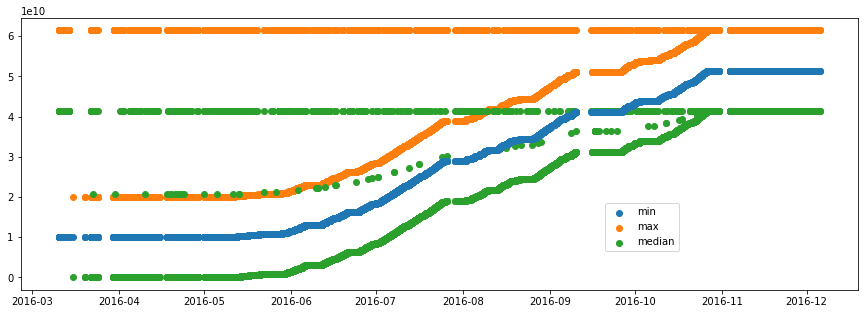

In [33]:
#now we can plot the different lumi aggregration choices
fig, ax = plt.subplots(figsize=(15,5))

#note that each aggregate row may contain a different amount of crystals in it, so we'll select cases with at least 1 crystal
ax.scatter(comb_df[comb_df.num_not_nan > 0].datetime, comb_df[comb_df.num_not_nan > 0].int_lumi_min+1e10, label="min",zorder=10)
ax.scatter(comb_df[comb_df.num_not_nan > 0].datetime, comb_df[comb_df.num_not_nan > 0].int_lumi_max+2e10, label="max")
ax.scatter(comb_df[comb_df.num_not_nan > 0].datetime, comb_df[comb_df.num_not_nan > 0].int_lumi_median, label="median")

fig.legend(loc=(0.7,0.2))

It's really key here to see that the luminosity values can be _bad_. Each crystal is matched to the luminosity data based on the laser firing time (which is NaN anytime there was a calibration run but that specific crystal was not included). In these cases, the lumi matching essentially fails, and returns the last luminosity value row. There are often some number of crystals held out in a given calibration run (rows in these dataframes). This means that the median lumi (or really any aggregate lumi value) across the columns will be wrong. So, the best value is closest to the minimum. There will be subtle differences between crystals (because crystals fired upon are not necessarily fired on the same lumi-section (which is a short time interval). The minimum misses this nuance (which is probably too subtle for any current modelling goals). To re-iterate, the calibration values themselves do _not_ have this issue, because they only exist when the crystal is fired on and the aggregate values of them do not include NaN values.

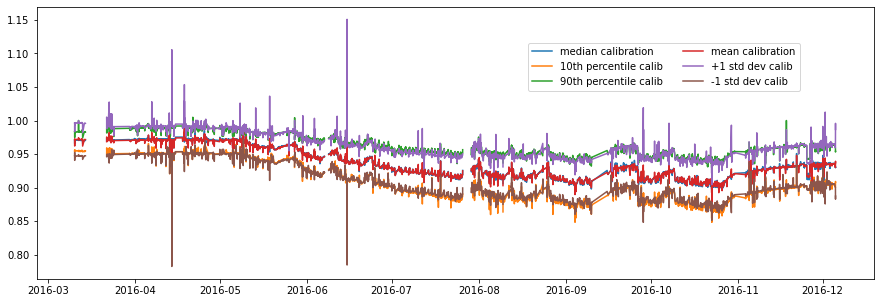

In [49]:
#lets plot different aggregate values
fig, ax = plt.subplots(figsize=(15,5))

#ax.scatter(comb_df.datetime, comb_df.int_lumi_min, label="integrated lumi")
ax.plot(comb_df.datetime, comb_df.calib_50, label='median calibration',   zorder=1)
ax.plot(comb_df.datetime, comb_df.calib_10, label='10th percentile calib',zorder=2)
ax.plot(comb_df.datetime, comb_df.calib_90, label='90th percentile calib',zorder=3)
ax.plot(comb_df.datetime, comb_df.calib_mean, label='mean calibration',zorder=11)
ax.plot(comb_df.datetime, comb_df.calib_mean+comb_df.calib_std_dev, label='+1 std dev calib',   zorder=12)
ax.plot(comb_df.datetime, comb_df.calib_mean-comb_df.calib_std_dev, label='-1 std dev calib',zorder=13)

fig.legend(ncol=2,loc=(0.6,0.7))

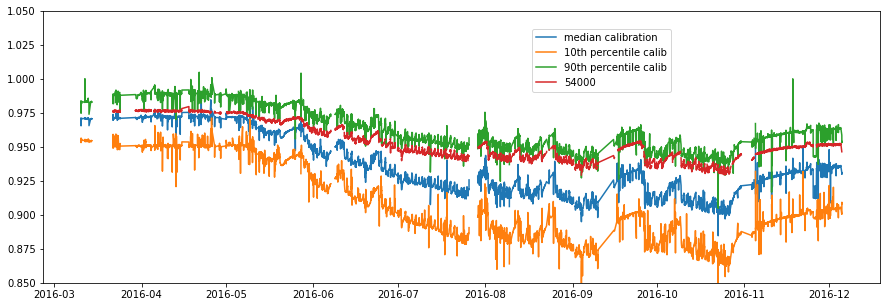

In [63]:
#lets plot different aggregate values
fig, ax = plt.subplots(figsize=(15,5))

ax.set_ylim(0.85,1.05)
#ax.scatter(comb_df.datetime, comb_df.int_lumi_min, label="integrated lumi")
ax.plot(comb_df.datetime, comb_df.calib_50, label='median calibration',   zorder=1)
ax.plot(comb_df.datetime, comb_df.calib_10, label='10th percentile calib',zorder=5)
ax.plot(comb_df.datetime, comb_df.calib_90, label='90th percentile calib',zorder=3)
#ax.plot(comb_df.datetime, comb_df.calib_mean, label='mean calibration',zorder=11)
#ax.plot(comb_df.datetime, comb_df.calib_mean+comb_df.calib_std_dev, label='+1 std dev calib',   zorder=12)
#ax.plot(comb_df.datetime, comb_df.calib_mean-comb_df.calib_std_dev, label='-1 std dev calib',zorder=13)
ax.plot(pd.to_datetime(df_54000.laser_datetime), df_54000.calibration, label="54000",zorder=10)

fig.legend(ncol=1,loc=(0.6,0.7))

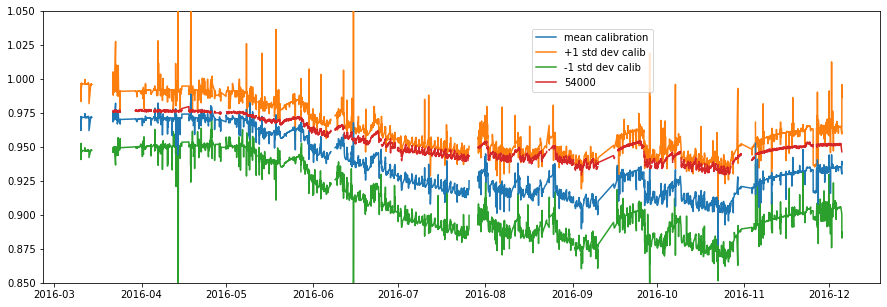

In [65]:
#lets plot different aggregate values
fig, ax = plt.subplots(figsize=(15,5))

ax.set_ylim(0.85,1.05)
#ax.scatter(comb_df.datetime, comb_df.int_lumi_min, label="integrated lumi")
#ax.plot(comb_df.datetime, comb_df.calib_50, label='median calibration',   zorder=1)
#ax.plot(comb_df.datetime, comb_df.calib_10, label='10th percentile calib',zorder=2)
#ax.plot(comb_df.datetime, comb_df.calib_90, label='90th percentile calib',zorder=3)
ax.plot(comb_df.datetime, comb_df.calib_mean, label='mean calibration',zorder=15)
ax.plot(comb_df.datetime, comb_df.calib_mean+comb_df.calib_std_dev, label='+1 std dev calib',   zorder=12)
ax.plot(comb_df.datetime, comb_df.calib_mean-comb_df.calib_std_dev, label='-1 std dev calib',zorder=13)

ax.plot(pd.to_datetime(df_54000.laser_datetime), df_54000.calibration, label="54000",zorder=20)

fig.legend(ncol=1,loc=(0.6,0.7))

In [67]:
#let's step back to the correlation matrix and look at problematic crystals
corr1

,54000,54001,54002,54003,54004,54005,54006,54007,54008,54009,...,54350,54351,54352,54353,54354,54355,54356,54357,54358,54359
54000,1.000000,0.993903,0.989642,0.997795,0.997734,0.989956,0.997090,0.989063,0.996184,0.979965,...,0.997482,0.924229,0.992900,0.990290,0.981570,0.985609,0.996438,0.994635,0.997692,0.997473
54001,0.993903,1.000000,0.996363,0.993005,0.993914,0.998344,0.989382,0.997311,0.999057,0.960205,...,0.990571,0.958455,0.982855,0.973041,0.990949,0.965171,0.985654,0.989278,0.989910,0.997284
54002,0.989642,0.996363,1.000000,0.984237,0.986638,0.997881,0.979458,0.998214,0.995829,0.943609,...,0.982120,0.965880,0.972624,0.962978,0.997337,0.954467,0.976873,0.981024,0.982309,0.992105
54003,0.997795,0.993005,0.984237,1.000000,0.999190,0.986780,0.999237,0.985400,0.995037,0.985471,...,0.999188,0.919833,0.996499,0.991322,0.974633,0.986550,0.997700,0.997403,0.998827,0.997434
54004,0.997734,0.993914,0.986638,0.999190,1.000000,0.987774,0.997619,0.986376,0.996248,0.981132,...,0.998332,0.926242,0.996834,0.987737,0.977716,0.982173,0.995883,0.998619,0.998115,0.997699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54355,0.985609,0.965171,0.954467,0.986550,0.982173,0.957475,0.990591,0.956719,0.970716,0.993829,...,0.989375,0.859550,0.987183,0.999257,0.946004,1.000000,0.994617,0.981873,0.990509,0.979568
54356,0.996438,0.985654,0.976873,0.997700,0.995883,0.979052,0.998480,0.978202,0.989185,0.989770,...,0.998870,0.903671,0.996399,0.997467,0.969536,0.994617,1.000000,0.995217,0.999230,0.994514
54357,0.994635,0.989278,0.981024,0.997403,0.998619,0.981472,0.995460,0.980431,0.992510,0.980373,...,0.997716,0.921964,0.998821,0.987218,0.974182,0.981873,0.995217,1.000000,0.997601,0.995698
54358,0.997692,0.989910,0.982309,0.998827,0.998115,0.983818,0.998338,0.983026,0.993061,0.985318,...,0.999581,0.916186,0.997372,0.994491,0.975535,0.990509,0.999230,0.997601,1.000000,0.997106


In [70]:
#the average correlation
avg_corr = corr1.apply(lambda x: x.mean())

Text(0.5, 1.0, 'Average Correlation Histogram')

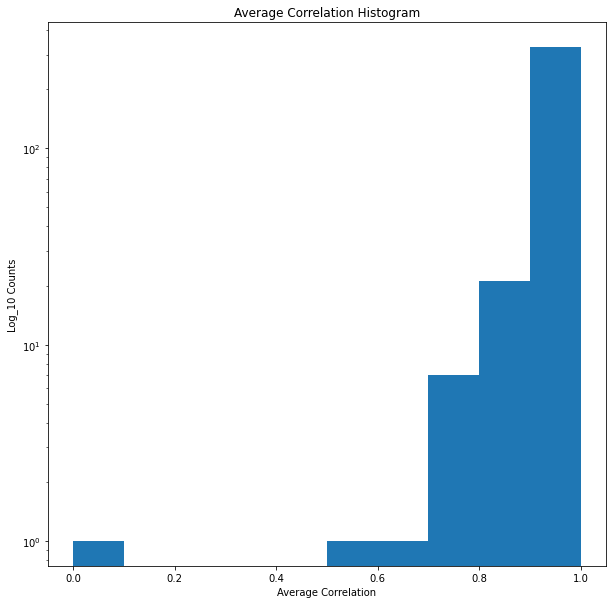

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(avg_corr, bins=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],log=True)
ax.set_xlabel("Average Correlation")
ax.set_ylabel("Log_10 Counts")
ax.set_title("Average Correlation Histogram")

In [91]:
#we've got some bad, and some really bad crystals. Let's cut out crystals with a correlation under 0.9 (which is about 5% of crystals)
good_xtal = avg_corr > 0.9

In [110]:
#a little fanciness to mask out the 'bad' crystals
good_col_idx = np.arange(0,calibrations.shape[1])[good_xtal]

In [112]:
#now we take the multidataframe of calibrations and drop the 'bad' crystals
good_calibrations = calibrations.iloc[:,good_col_idx]

In [113]:
#remake aggregate info
good_calib_median_series = good_calibrations.apply(lambda x: x.median(), axis=1)
good_calib_upper_series  = good_calibrations.apply(lambda x: x.quantile(0.9), axis=1)
good_calib_lower_series  = good_calibrations.apply(lambda x: x.quantile(0.1), axis=1)
good_calib_mean_series   = good_calibrations.apply(lambda x: x.mean(), axis=1)
good_calib_std_dev_series= good_calibrations.apply(lambda x: x.std(), axis=1)

In [116]:
#add it to the dataframe
comb_df['calib_50_good'] = good_calib_median_series
comb_df['calib_10_good'] = good_calib_lower_series
comb_df['calib_90_good'] = good_calib_upper_series
comb_df['calib_mean_good'] = good_calib_mean_series
comb_df['calib_std_dev_good'] = good_calib_std_dev_series

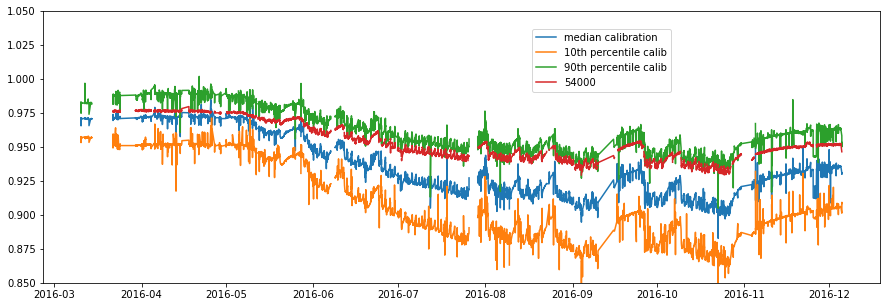

In [118]:
#lets plot different aggregate values
fig, ax = plt.subplots(figsize=(15,5))

ax.set_ylim(0.85,1.05)
#ax.scatter(comb_df.datetime, comb_df.int_lumi_min, label="integrated lumi")
ax.plot(comb_df.datetime, comb_df.calib_50_good, label='median calibration',   zorder=1)
ax.plot(comb_df.datetime, comb_df.calib_10_good, label='10th percentile calib',zorder=5)
ax.plot(comb_df.datetime, comb_df.calib_90_good, label='90th percentile calib',zorder=3)
#ax.plot(comb_df.datetime, comb_df.calib_mean, label='mean calibration',zorder=11)
#ax.plot(comb_df.datetime, comb_df.calib_mean+comb_df.calib_std_dev, label='+1 std dev calib',   zorder=12)
#ax.plot(comb_df.datetime, comb_df.calib_mean-comb_df.calib_std_dev, label='-1 std dev calib',zorder=13)
ax.plot(pd.to_datetime(df_54000.laser_datetime), df_54000.calibration, label="54000",zorder=10)

fig.legend(ncol=1,loc=(0.6,0.7))

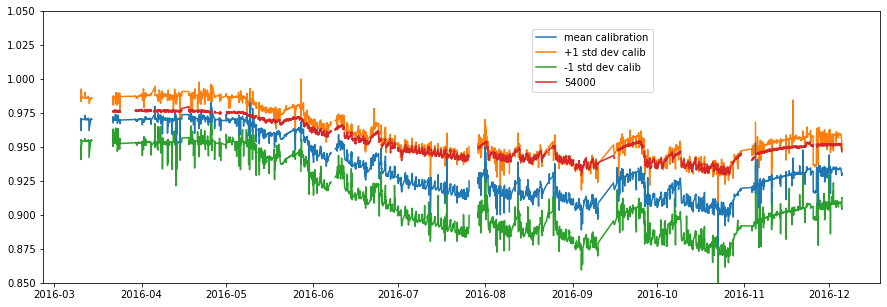

In [119]:
#lets plot different aggregate values
fig, ax = plt.subplots(figsize=(15,5))

ax.set_ylim(0.85,1.05)
#ax.scatter(comb_df.datetime, comb_df.int_lumi_min, label="integrated lumi")
#ax.plot(comb_df.datetime, comb_df.calib_50, label='median calibration',   zorder=1)
#ax.plot(comb_df.datetime, comb_df.calib_10, label='10th percentile calib',zorder=2)
#ax.plot(comb_df.datetime, comb_df.calib_90, label='90th percentile calib',zorder=3)
ax.plot(comb_df.datetime, comb_df.calib_mean_good, label='mean calibration',zorder=15)
ax.plot(comb_df.datetime, comb_df.calib_mean_good+comb_df.calib_std_dev_good, label='+1 std dev calib',   zorder=12)
ax.plot(comb_df.datetime, comb_df.calib_mean_good-comb_df.calib_std_dev_good, label='-1 std dev calib',zorder=13)

ax.plot(pd.to_datetime(df_54000.laser_datetime), df_54000.calibration, label="54000",zorder=20)

fig.legend(ncol=1,loc=(0.6,0.7))

In [ ]:
#now we'll save, and it remembers the year from the beginning!
comb_df.to_csv('../dataframes/'+year+'_ring66_comb.csv')